### This is the second test to analyze the data in a train view

This time, i want to quantify the reliability of one train service code, based on yearly data!! So, not so much a one-day analysis, but an overall assessment of how this service operates, is it vulerable in general? so you can test different train services and compare!


**Parameters:**

inputs:

- `train origin and destination`
- `date`


outputs:

- `overall train journey`: what did the train encounter?

In [10]:
# Import required libraries for station_view function
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime, timedelta
import sys
import matplotlib.pyplot as plt
import geopandas as gpd
import json
import folium
from folium import plugins
from train_view_T1 import get_stanox_for_service


print(" Libraries imported successfully for station_view analysis")

 Libraries imported successfully for station_view analysis


In [4]:
# Load all .parquet files from processed_data into a pandas DataFrame, trying both pyarrow and fastparquet engines

data_dir = '../processed_data' if not os.path.isdir('processed_data') else 'processed_data'
all_parquet_files = glob.glob(os.path.join(data_dir, '*', '*.parquet'))

list_df = []
skipped_files = []
for file in all_parquet_files:
    try:
        df = pd.read_parquet(file)
    except Exception as e1:
        try:
            df = pd.read_parquet(file, engine='fastparquet')
        except Exception as e2:
            skipped_files.append(file)
            continue
    stanox = os.path.basename(os.path.dirname(file))
    day = os.path.splitext(os.path.basename(file))[0]
    df['STANOX'] = stanox
    df['DAY'] = day
    list_df.append(df)  # adding stanox and day columns 

if list_df:
    all_data = pd.concat(list_df, ignore_index=True)
    print(f"Loaded {len(all_data)} rows from {len(list_df)} files.")

else:
    all_data = pd.DataFrame()
    print("No data loaded.")

Loaded 10450237 rows from 2599 files.


just for quick access during the test

In [5]:
all_data.columns.tolist() # Display the columns of the combined DataFrame

['TRAIN_SERVICE_CODE',
 'PLANNED_ORIGIN_LOCATION_CODE',
 'PLANNED_ORIGIN_GBTT_DATETIME',
 'PLANNED_DEST_LOCATION_CODE',
 'PLANNED_DEST_GBTT_DATETIME',
 'PLANNED_CALLS',
 'ACTUAL_CALLS',
 'PFPI_MINUTES',
 'INCIDENT_REASON',
 'INCIDENT_NUMBER',
 'EVENT_TYPE',
 'SECTION_CODE',
 'DELAY_DAY',
 'EVENT_DATETIME',
 'INCIDENT_START_DATETIME',
 'ENGLISH_DAY_TYPE',
 'STATION_ROLE',
 'DFT_CATEGORY',
 'PLATFORM_COUNT',
 'DATASET_TYPE',
 'WEEKDAY',
 'STANOX',
 'DAY']

I know to define these stations as OD pair and service code from train view T1!!

In [11]:
service_stanox = get_stanox_for_service(all_data, '12357820', '11231', '32530')

✅ Ordered STANOX for first train of the day for service 12357820 on OD pair 11231_32530 (origin always first):
['11231', '11271', '11720', '30120', '31620', '33087', '32000', '31521', '32530']


In [28]:
def train_view_2(all_data, service_stanox, service_code, stations_ref_path=r"C:\Users\39342\University of Glasgow\Ji-Eun Byun - MZ-JB\MSci (Research) 2024-25\reference data\stations_ref_with_dft.json"):
    """
    Compute reliability metrics for each station in the service_stanox list for a given train service code.

    Metrics now exclude PFPI_MINUTES == 0.0 when computing mean/variance and incident counts.
    OnTime% is computed on the original PFPI distribution (<=0) so it still reflects punctuality.

    Returns a DataFrame with columns: ServiceCode, StationName, MeanDelay, DelayVariance, OnTime%, IncidentCount
    """
    import json
    import pandas as pd
    import numpy as np

    # Load station reference
    try:
        with open(stations_ref_path, "r") as f:
            station_ref = json.load(f)
        stanox_to_name = {str(item.get("stanox", "")): (item.get("description") or item.get("name") or str(item.get("stanox",""))) for item in station_ref}
    except Exception:
        stanox_to_name = {}

    results = []

    for s in service_stanox:
        # Filter data for this STANOX and service code
        subset = all_data[
            (all_data['STANOX'] == str(s)) &
            (all_data['TRAIN_SERVICE_CODE'].astype(str) == str(service_code))
        ].copy()

        if subset.empty:
            continue

        # Convert PFPI_MINUTES to numeric (keep full series for on-time calc)
        pfpi_all = pd.to_numeric(subset['PFPI_MINUTES'], errors='coerce').dropna()
        # On-time percentage (<= 0 minutes)
        on_time_pct = (pfpi_all <= 0).sum() / len(pfpi_all) * 100 if len(pfpi_all) > 0 else np.nan

        # Exclude 0.0 delays for mean/variance and incident counting
        pfpi_pos = pfpi_all[pfpi_all > 0]
        mean_delay = pfpi_pos.mean() if len(pfpi_pos) > 0 else np.nan
        delay_variance = pfpi_pos.var() if len(pfpi_pos) > 0 else np.nan
        incident_count = len(pfpi_pos)

        station_name = stanox_to_name.get(str(s), f"{s}")

        results.append({
            'ServiceCode': service_code,
            'StationName': station_name,
            'MeanDelay': mean_delay,
            'DelayVariance': delay_variance,
            'OnTime%': on_time_pct,
            'IncidentCount': incident_count
        })

    return pd.DataFrame(results)

In [29]:
result_table = train_view_2(all_data, service_stanox, '12357820')

result_table

,ServiceCode,StationName,MeanDelay,DelayVariance,OnTime%,IncidentCount
0,12357820,Dalton,NaN,NaN,100.000000,0
1,12357820,Lancaster,9.617086,150.413570,82.654141,1311
2,12357820,Preston,15.186947,183.612237,83.562142,1808
3,12357820,C H S,4.708543,46.747966,82.111211,1393
4,12357820,Manchester Oxford Road,11.786458,146.900885,83.216783,768
5,12357820,Manchester Piccadilly,10.015915,128.725853,82.475984,1131
6,12357820,Salford Crescent,4.194944,9.063515,0.000000,2611
7,12357820,Manchester Airport,11.472906,277.121337,83.923975,812


In [46]:
def plot_reliability_graphs(all_data, service_stanox, service_code, stations_ref_path=r"C:\Users\39342\University of Glasgow\Ji-Eun Byun - MZ-JB\MSci (Research) 2024-25\reference data\stations_ref_with_dft.json", cap_minutes=75):
    """
    Generate overlapping density (KDE) curves and cumulative distribution plots: Delay distribution per station (all curves overlapping, different colours), excluding delay==0.0 and capped at cap_minutes.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # try to get station names
    try:
        import json
        with open(stations_ref_path, 'r') as f:
            station_ref = json.load(f)
        stanox_to_name = {str(item.get('stanox','')): item.get('description') or item.get('name') or str(item.get('stanox','')) for item in station_ref}
    except Exception:
        stanox_to_name = {}

    station_labels = []
    delay_data = []

    for s in service_stanox:
        subset = all_data[
            (all_data['STANOX'] == str(s)) &
            (all_data['TRAIN_SERVICE_CODE'].astype(str) == str(service_code))
        ].copy()

        if subset.empty:
            continue

        # convert pfpi and drop nan
        pfpi_all = pd.to_numeric(subset['PFPI_MINUTES'], errors='coerce').dropna()
        # exclude zeros for plotting/stats (per user request)
        pfpi_pos = pfpi_all[pfpi_all > 0]
        delays = pfpi_pos.values
        if len(delays) == 0:
            continue

        label = stanox_to_name.get(str(s), str(s))
        station_labels.append(label)
        delay_data.append(delays)

    if not station_labels:
        print('No data to plot.')
        return

    # Graph 1: Overlapping density plots (KDE) per station
    plt.figure(figsize=(10, 6))

    cmap = plt.get_cmap('tab10')
    n = len(delay_data)
    colors = [cmap(i % cmap.N) for i in range(n)]

    # Determine x range from percentiles but cap at cap_minutes
    all_vals = np.concatenate(delay_data)
    xmin = max(0, np.nanpercentile(all_vals, 1))
    xmax = np.nanpercentile(all_vals, 99)
    x_vals = np.linspace(xmin, xmax, 400)

    try:
        import seaborn as sns
        for i, delays in enumerate(delay_data):
            # clip delays to [0, cap_minutes]
            clipped = np.clip(delays, 0, cap_minutes)
            sns.kdeplot(clipped, bw_adjust=1, label=station_labels[i], color=colors[i], fill=False, clip=(0, cap_minutes))
    except Exception:
        try:
            from scipy.stats import gaussian_kde
            for i, delays in enumerate(delay_data):
                clipped = np.clip(delays, 0, cap_minutes)
                try:
                    kde = gaussian_kde(clipped)
                    y = kde(x_vals)
                except Exception:
                    y = np.zeros_like(x_vals)
                    hist_vals, bin_edges = np.histogram(clipped, bins=20, density=True)
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    y = np.interp(x_vals, bin_centers, hist_vals, left=0, right=0)
                plt.plot(x_vals, y, label=station_labels[i], color=colors[i])
        except Exception:
            for i, delays in enumerate(delay_data):
                clipped = np.clip(delays, 0, cap_minutes)
                hist_vals, bin_edges = np.histogram(clipped, bins=30, density=True)
                bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                plt.plot(bin_centers, hist_vals, label=station_labels[i], color=colors[i])

    plt.xlim(0, cap_minutes)
    plt.xlabel('Delay (minutes)')
    plt.ylabel('PDF')
    plt.title(f'Delay Distribution per Station (overlapping KDEs, capped at {cap_minutes} min)')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # Graph 2: Cumulative distribution plots per station
    plt.figure(figsize=(10, 6))

    for i, delays in enumerate(delay_data):
        clipped = np.clip(delays, 0, cap_minutes)
        sorted_delays = np.sort(clipped)
        y = np.arange(1, len(sorted_delays) + 1) / len(sorted_delays)
        plt.plot(sorted_delays, y, label=station_labels[i], color=colors[i])

    plt.xlim(0, cap_minutes)
    plt.xlabel('Delay (minutes)')
    plt.ylabel('CDF')
    plt.title(f'Cumulative Delay Distribution per Station (capped at {cap_minutes} min)')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

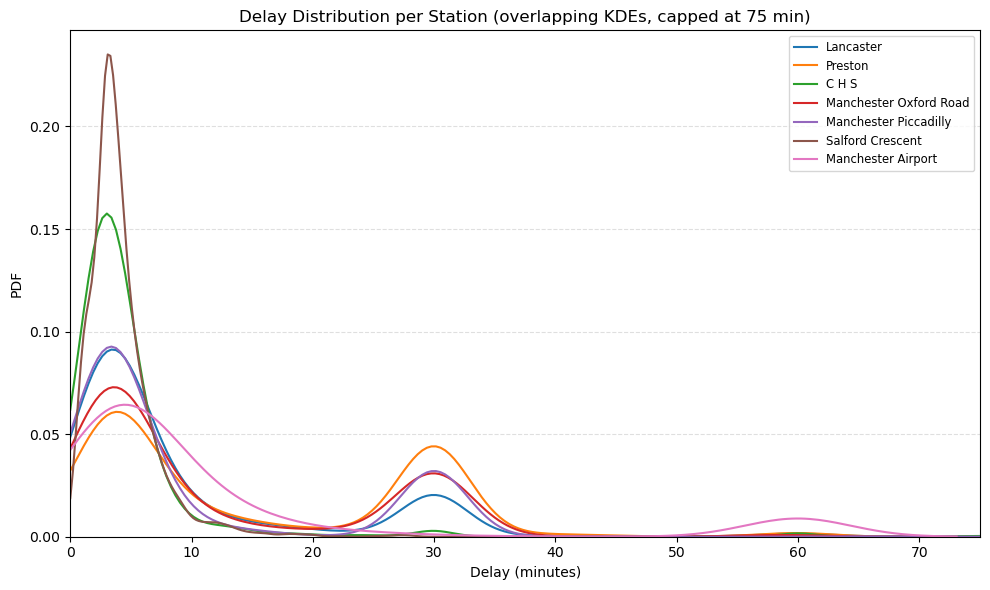

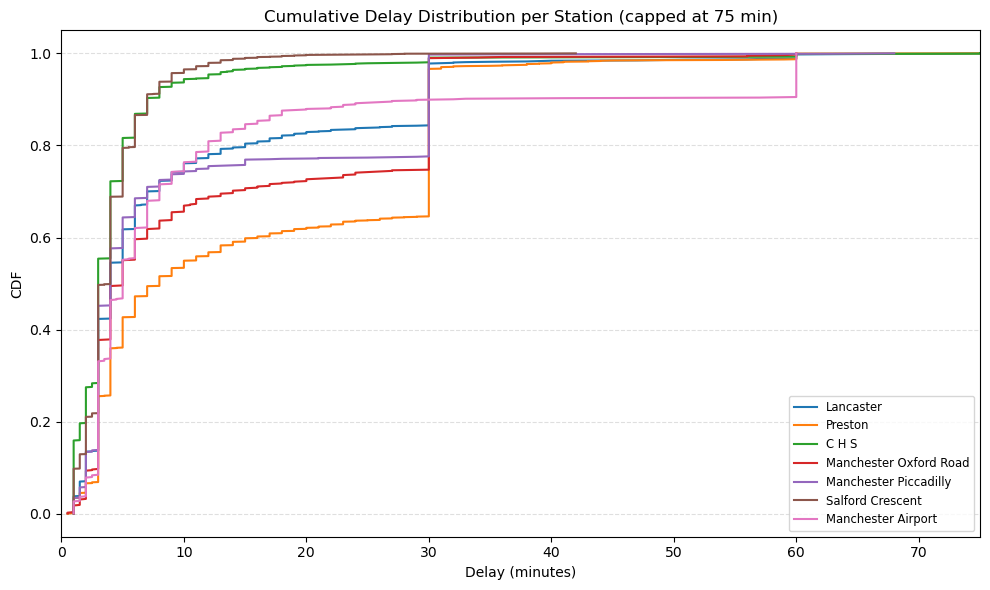

In [47]:
plot_reliability_graphs(all_data, service_stanox, '12357820') # service_stanox is the list of stations for this service code